# Predicting Mahjong Discard Decisions with Machine Learning

This notebook builds a multiclass classifier that predicts which tile a player will discard next, using real Riichi Mahjong game states extracted from Tenhou logs.


In [24]:
import sqlite3
import gzip
import json

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (8, 4)

## 1. Data Loading

We randomly sample discard states from the `Discard` table in the SQLite database. Each row holds a compressed JSON snapshot of the game state plus some metadata like `MaxDan` and `MinDan`.


In [25]:
db_path = "/Users/calvi/Downloads/datasets_positive.db"
TABLE = "Discard"
JSON_COL = "Data"

N_SAMPLES = 50000  

conn = sqlite3.connect(db_path)
cur = conn.cursor()

query = f"""
    SELECT {JSON_COL}, MaxDan, MinDan
    FROM {TABLE}
    ORDER BY RANDOM()
    LIMIT {N_SAMPLES};
"""

rows = cur.execute(query).fetchall()
conn.close()

len(rows)


50000

In [26]:
def parse_state_to_features_and_label(state: dict, max_dan: int, min_dan: int):
    """
    Convert a single Mahjong state into:
      - feature list
      - label = tile type (0-33) for the discarded tile

    Returns (features, label) or (None, None) if unusable.
    """
    feats = []

    # DB-level skill features
    feats.append(max_dan if max_dan is not None else 0)
    feats.append(min_dan if min_dan is not None else 0)

    # Round info
    feats.append(state.get("round_wind", 0))
    feats.append(state.get("num_honba", 0))
    feats.append(state.get("num_riichi", 0))
    feats.append(state.get("remain_tiles", 0))

    # Player identity
    player_wind = state.get("player_wind", 0)
    position = state.get("position", 0)
    feats.append(player_wind)
    feats.append(position)

    # Dora count
    dora_inds = state.get("dora_indicators", []) or []
    feats.append(len(dora_inds))

    # Hand tile counts (34 types)
    hand_counts = [0] * 34
    for tid in state.get("hand_tiles", []) or []:
        idx = tid // 4
        if 0 <= idx < 34:
            hand_counts[idx] += 1
    feats.extend(hand_counts)

    # Current player public info
    player_block = state.get(str(player_wind), {}) or {}
    curr_points = player_block.get("points", 0)
    feats.append(curr_points)

    curr_riichi_flag = 1 if player_block.get("riichi", False) else 0
    feats.append(curr_riichi_flag)

    # Opponent pressure
    opp_riichi = 0
    opp_melds = 0
    for pid in range(4):
        pdata = state.get(str(pid), {}) or {}
        if pid != player_wind and pdata.get("riichi", False):
            opp_riichi += 1
        opp_melds += len(pdata.get("melds", []) or [])
    feats.append(opp_riichi)
    feats.append(opp_melds)

    # Label: tile type from chosen discard action
    valid_actions = state.get("valid_actions", []) or []
    if not valid_actions:
        return None, None

    chosen_idx = state.get("real_action_idx", state.get("action_idx"))
    if (
        chosen_idx is None
        or chosen_idx < 0
        or chosen_idx >= len(valid_actions)
    ):
        return None, None

    chosen_action = valid_actions[chosen_idx]
    a_type = chosen_action.get("type")

    # 1 = discard, 7 = riichi (discard + riichi)
    if a_type not in (1, 7):
        return None, None

    tiles = chosen_action.get("tiles", [])
    if not tiles:
        return None, None

    tile_id = tiles[0]
    if tile_id is None or tile_id < 0:
        return None, None

    tile_type = tile_id // 4   

    return feats, tile_type


In [27]:
X_list = []
y_list = []

for blob, max_dan, min_dan in tqdm(rows, desc="Parsing states"):
    if blob is None:
        continue
    try:
        state = json.loads(gzip.decompress(blob))
    except Exception:
        continue

    feats, label = parse_state_to_features_and_label(state, max_dan, min_dan)
    if feats is None:
        continue

    X_list.append(feats)
    y_list.append(label)

len(X_list), len(y_list)


Parsing states:   0%|          | 0/50000 [00:00<?, ?it/s]

(50000, 50000)

## 3. Build Dataset

We convert the feature lists to a NumPy array and inspect the shape and label distribution.


In [28]:
X = np.array(X_list, dtype=np.float32)
y = np.array(y_list, dtype=np.int64)

X.shape, y.shape


((50000, 47), (50000,))

0     2015
1     1409
2     1023
3      843
4      738
5      888
6      962
7     1396
8     1983
9     1986
10    1382
11     966
12     893
13     809
14     902
15    1020
16    1436
17    2014
18    2012
19    1368
20    1014
21     872
22     793
23     927
24     979
25    1387
26    1973
27    2238
28    2221
29    2390
30    2410
31    2276
32    2295
33    2180
dtype: int64

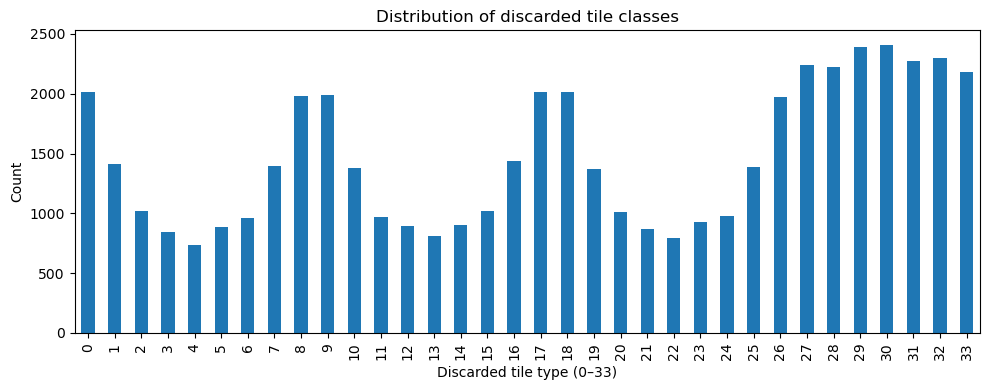

In [29]:
unique, counts = np.unique(y, return_counts=True)
label_counts = pd.Series(counts, index=unique).sort_index()

display(label_counts)

plt.figure(figsize=(10, 4))
label_counts.plot(kind="bar")
plt.xlabel("Discarded tile type (0–33)")
plt.ylabel("Count")
plt.title("Distribution of discarded tile classes")
plt.tight_layout()
plt.show()


## 4. Train/Test Split and Scaling

We use a 75/25 stratified split to preserve label proportions.  
Standardization is applied for Logistic Regression only.


In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=RANDOM_STATE,
    stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

X_train.shape, X_test.shape


((37500, 47), (12500, 47))

## 5. Baseline Model

The baseline always predicts the most frequent discard tile in the training set.


In [31]:
from sklearn.metrics import f1_score

# most frequent class in training set
most_common = pd.Series(y_train).value_counts().idxmax()

y_pred_base = np.full_like(y_test, fill_value=most_common)

base_acc = accuracy_score(y_test, y_pred_base)
base_f1_macro = f1_score(y_test, y_pred_base, average="macro")

print("Baseline most-frequent class:", most_common)
print("Baseline accuracy:", base_acc)
print("Baseline macro F1:", base_f1_macro)


Baseline most-frequent class: 30
Baseline accuracy: 0.04816
Baseline macro F1: 0.0027027755080050644


## 6. Multinomial Logistic Regression

We fit a multinomial Logistic Regression model as a linear baseline.


In [32]:
lr = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=300,
    n_jobs=1 
)

lr.fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_f1_macro = f1_score(y_test, y_pred_lr, average="macro")

print("Logistic Regression Accuracy:", lr_acc)
print("Logistic Regression Macro F1:", lr_f1_macro)
print("\nClassification report (LogReg):")
print(classification_report(y_test, y_pred_lr, digits=3))


/Users/calvi/Downloads/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression Accuracy: 0.12488
Logistic Regression Macro F1: 0.09490487547168582

Classification report (LogReg):
              precision    recall  f1-score   support

           0      0.135     0.153     0.144       504
           1      0.063     0.057     0.060       352
           2      0.064     0.051     0.057       256
           3      0.052     0.038     0.044       211
           4      0.008     0.005     0.006       184
           5      0.051     0.036     0.042       222
           6      0.054     0.050     0.052       241
           7      0.078     0.074     0.076       349
           8      0.149     0.157     0.153       496
           9      0.130     0.145     0.137       497
          10      0.060     0.052     0.056       345
          11      0.049     0.037     0.042       242
          12      0.065     0.040     0.050       223
          13      0.028     0.020     0.023       202
          14      0.071     0.049     0.058       225
          15  

## 7. Random Forest Classifier

We next fit a non-linear Random Forest classifier, which can capture interactions between tiles and context.


In [33]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=1,         
    random_state=RANDOM_STATE
)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_f1_macro = f1_score(y_test, y_pred_rf, average="macro")

print("Random Forest Accuracy:", rf_acc)
print("Random Forest Macro F1:", rf_f1_macro)
print("\nClassification report (Random Forest):")
print(classification_report(y_test, y_pred_rf, digits=3))


Random Forest Accuracy: 0.41208
Random Forest Macro F1: 0.260527050214574

Classification report (Random Forest):
              precision    recall  f1-score   support

           0      0.361     0.464     0.406       504
           1      0.440     0.219     0.292       352
           2      0.368     0.082     0.134       256
           3      0.227     0.024     0.043       211
           4      0.235     0.022     0.040       184
           5      0.280     0.032     0.057       222
           6      0.268     0.062     0.101       241
           7      0.312     0.198     0.242       349
           8      0.376     0.464     0.415       496
           9      0.387     0.441     0.412       497
          10      0.393     0.209     0.273       345
          11      0.311     0.058     0.098       242
          12      0.154     0.018     0.032       223
          13      0.143     0.005     0.010       202
          14      0.400     0.027     0.050       225
          15      0.1

## 8. Model Comparison


In [34]:
results_df = pd.DataFrame({
    "Model": [
        "Baseline (most frequent)",
        "Logistic Regression",
        "Random Forest"
    ],
    "Accuracy": [
        base_acc,
        lr_acc,
        rf_acc
    ],
    "Macro F1": [
        base_f1_macro,
        lr_f1_macro,
        rf_f1_macro
    ]
})

results_df

,Model,Accuracy,Macro F1
0,Baseline (most frequent),0.04816,0.002703
1,Logistic Regression,0.12488,0.094905
2,Random Forest,0.41208,0.260527
